In [2]:
from os.path import join as pjoin
from os import listdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Figure 4
Recreating the firgures in figure 4

#### trial_response_side

-1 for left, 1 for right, nan for no choice

#### trial_reward

1 for rewarded, 0 for non-rewarded, nan for no choice

### Redo panel A

c:\Python37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


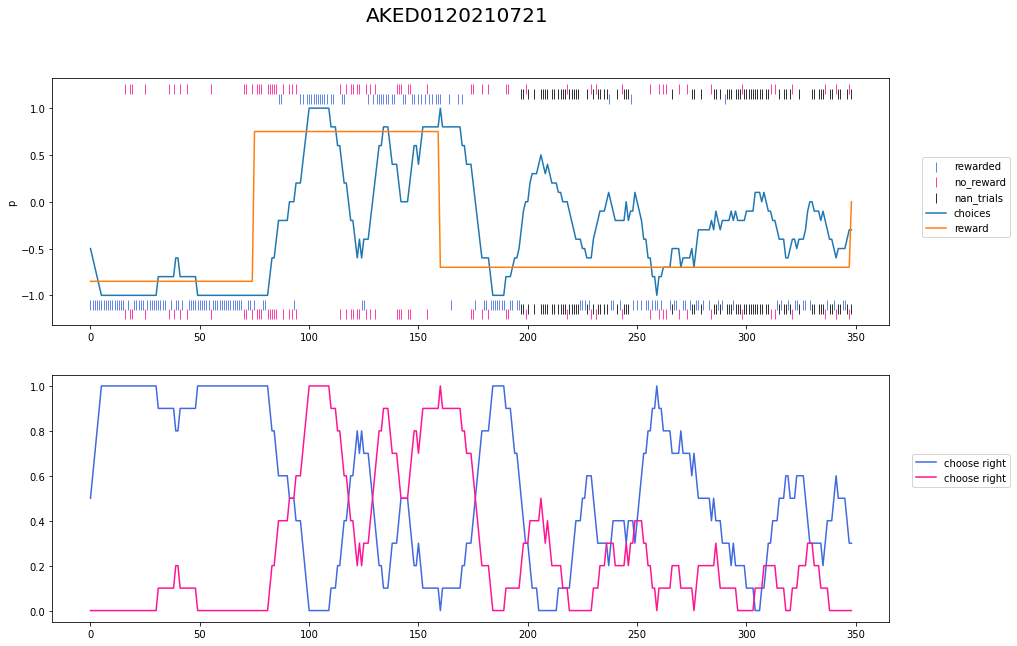

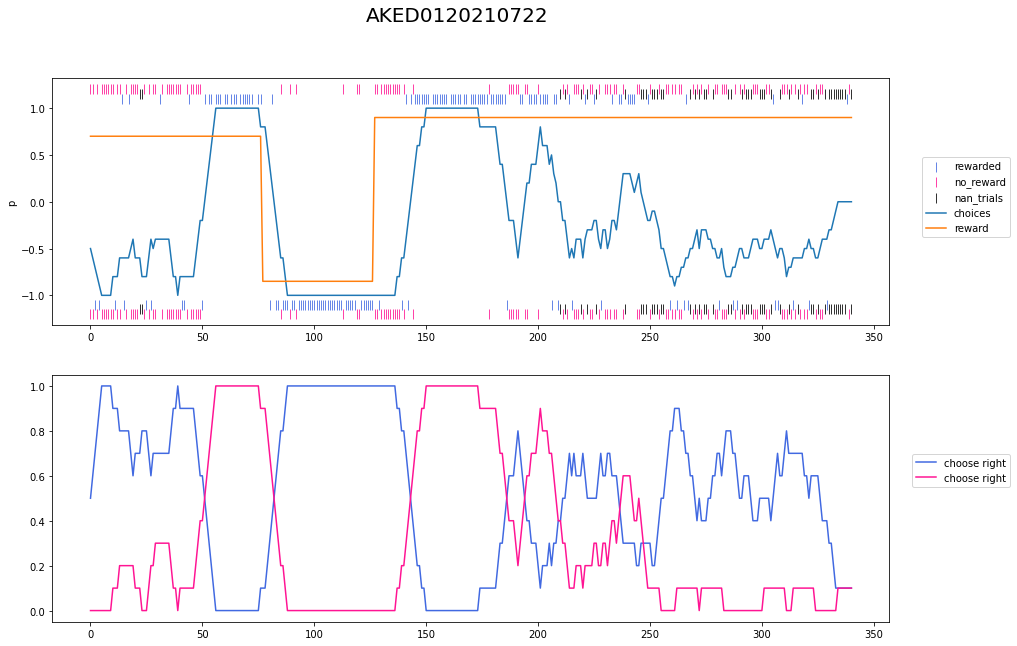

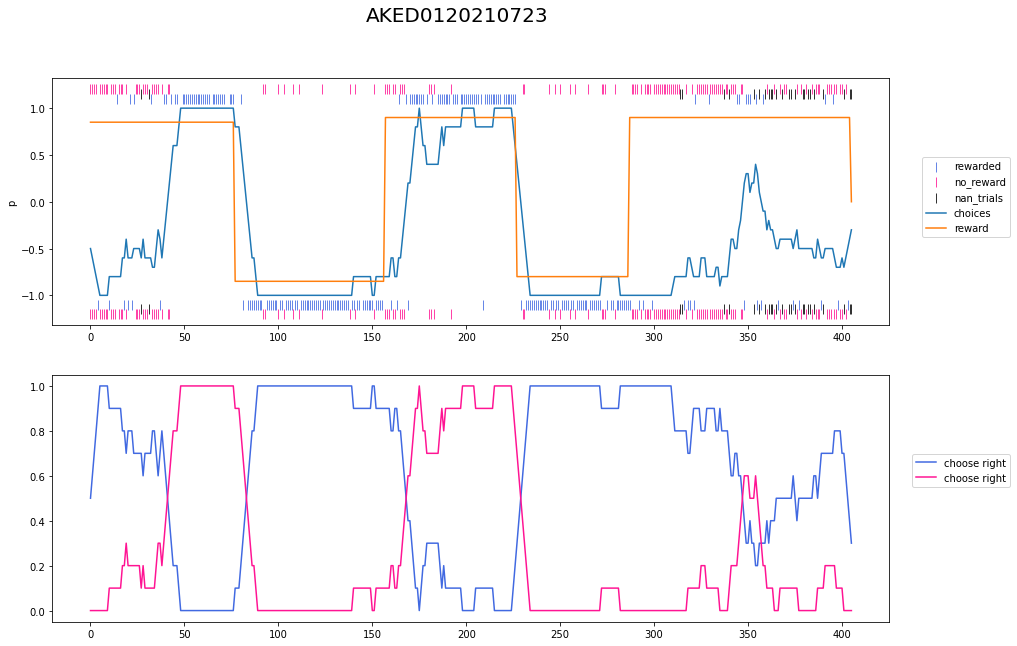

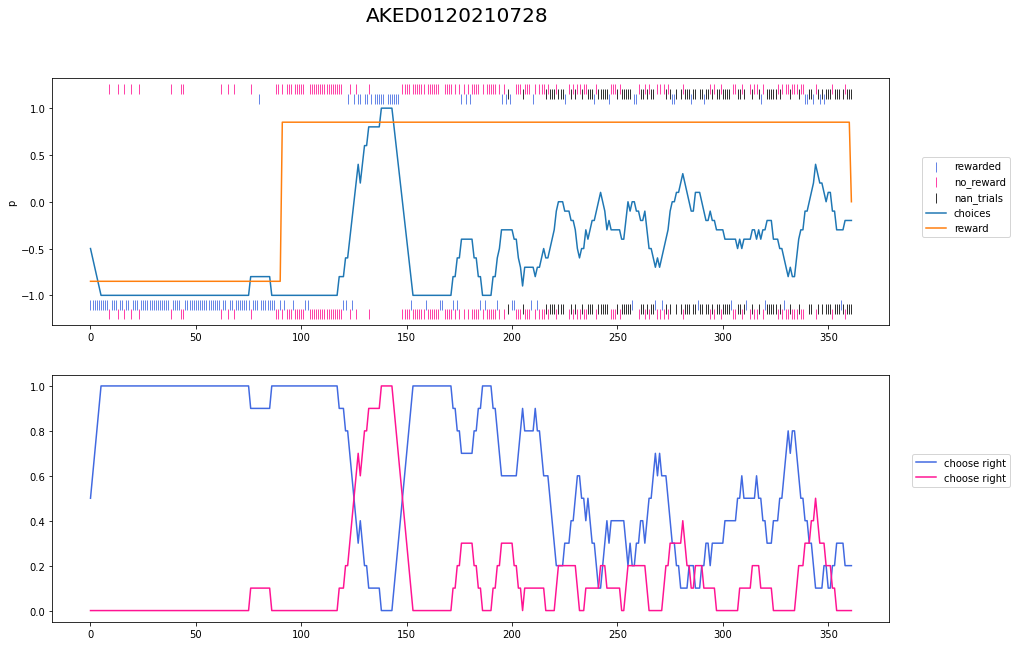

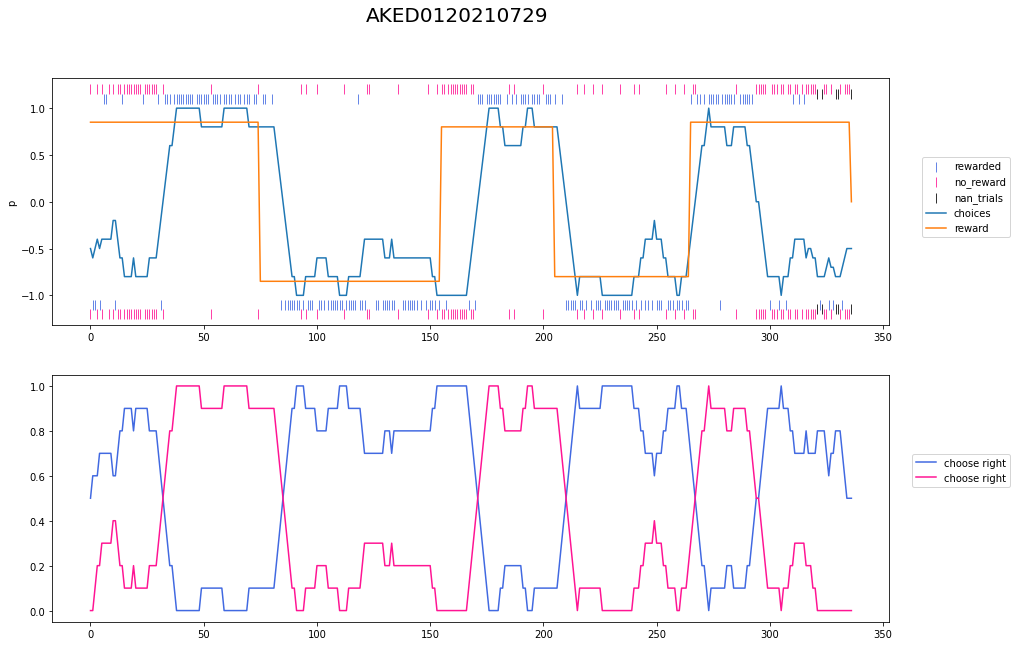

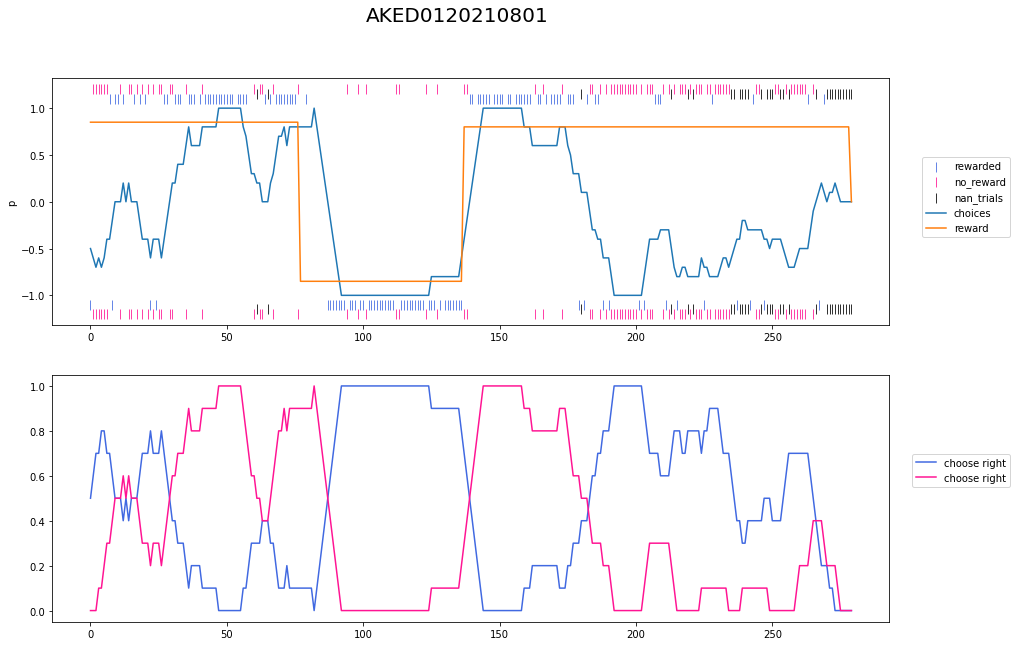

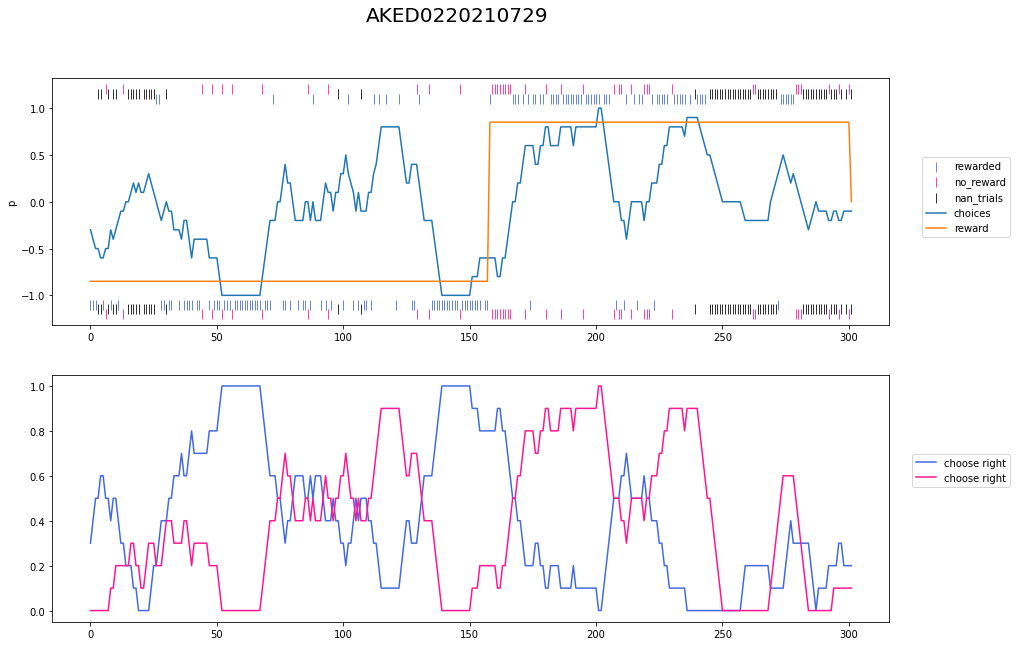

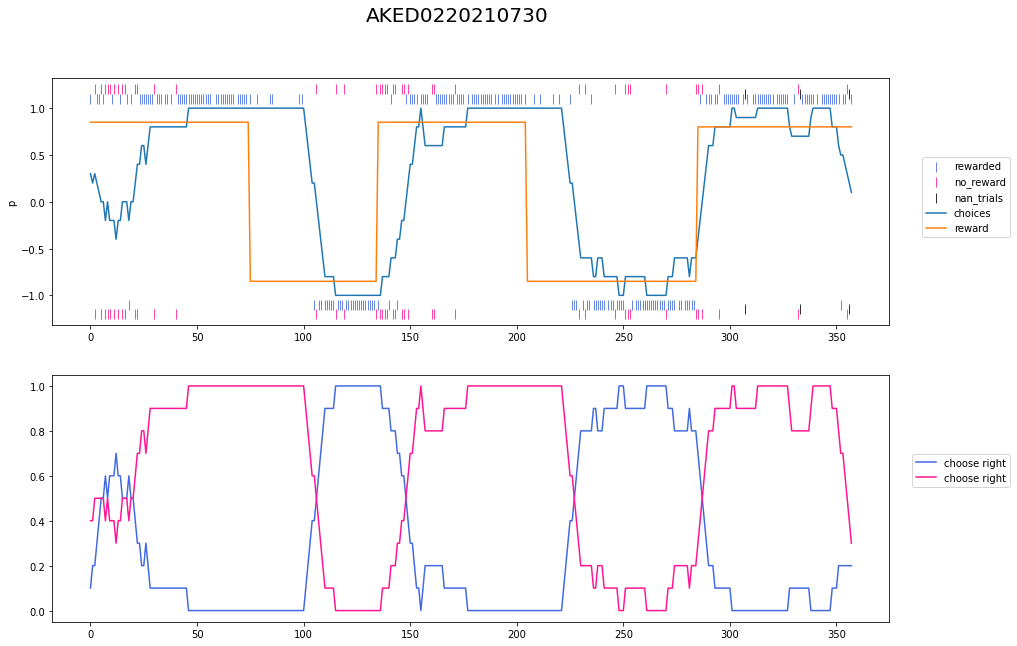

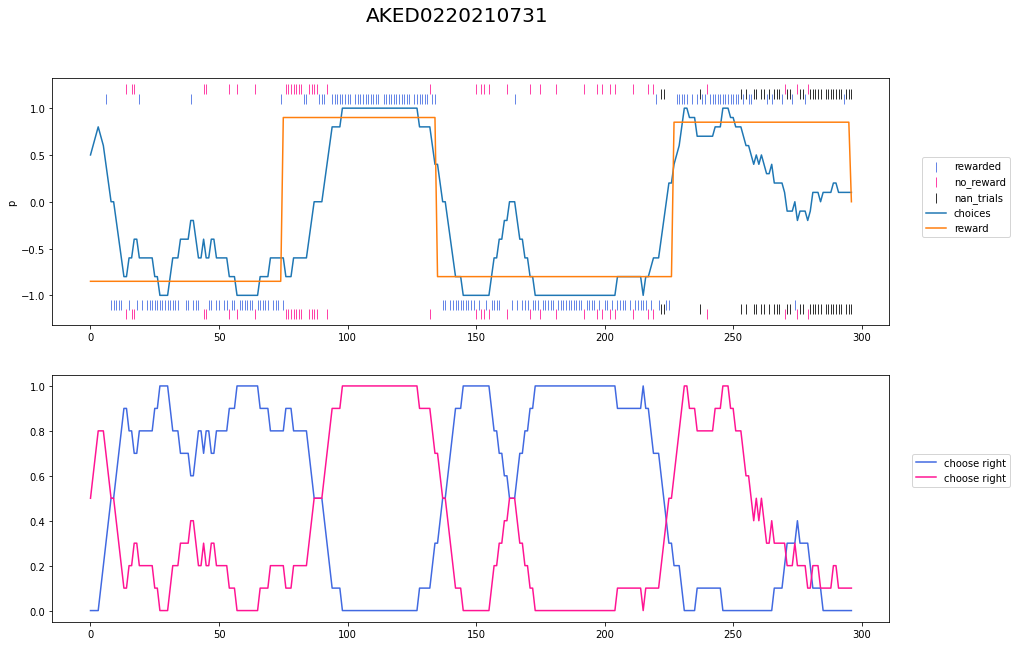

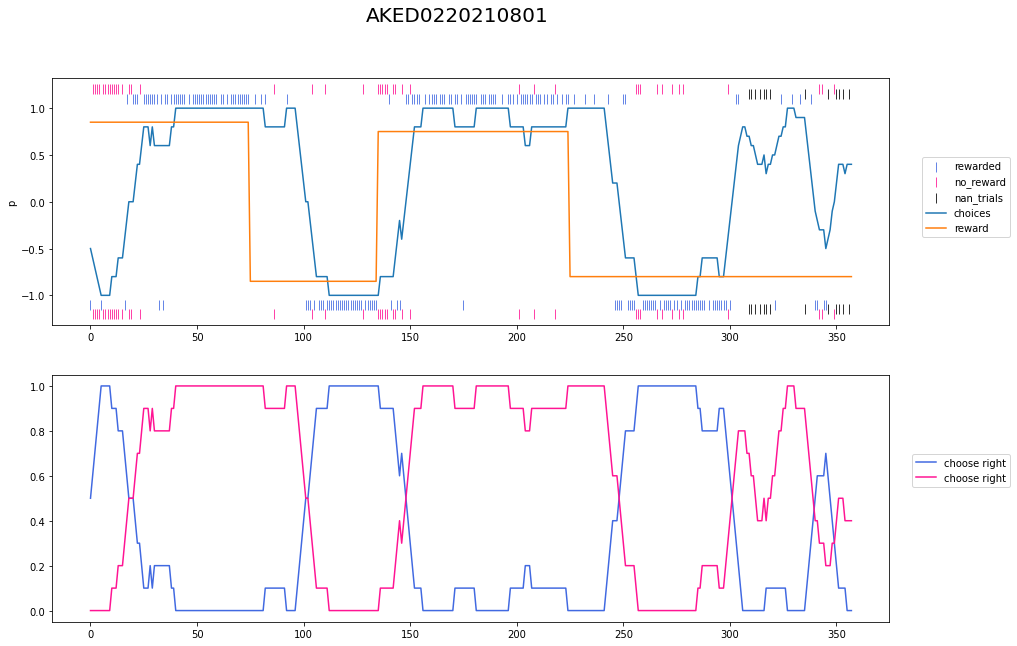

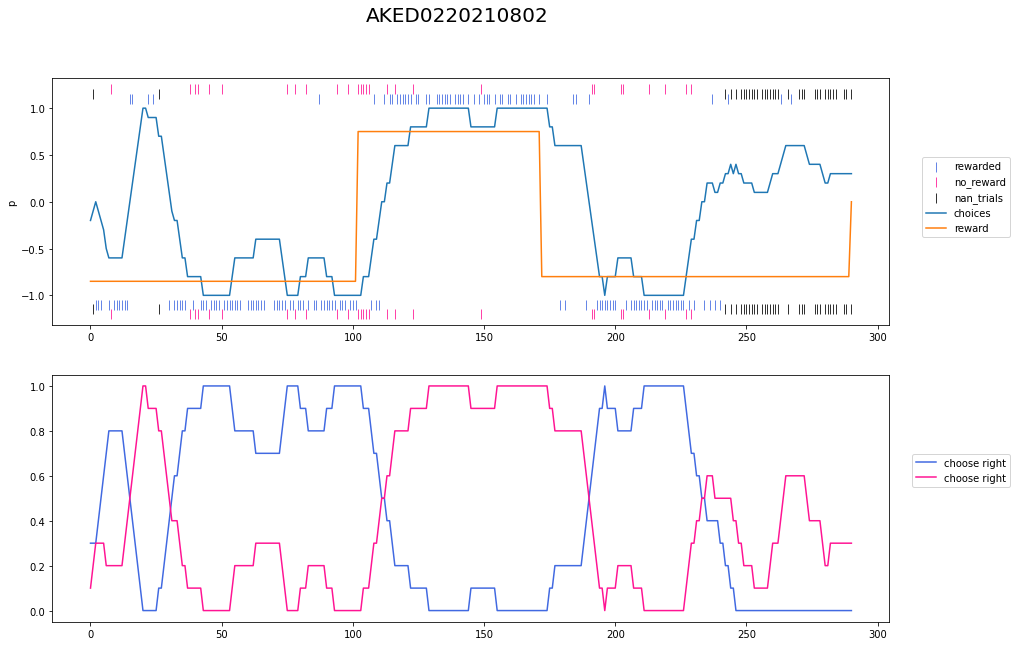

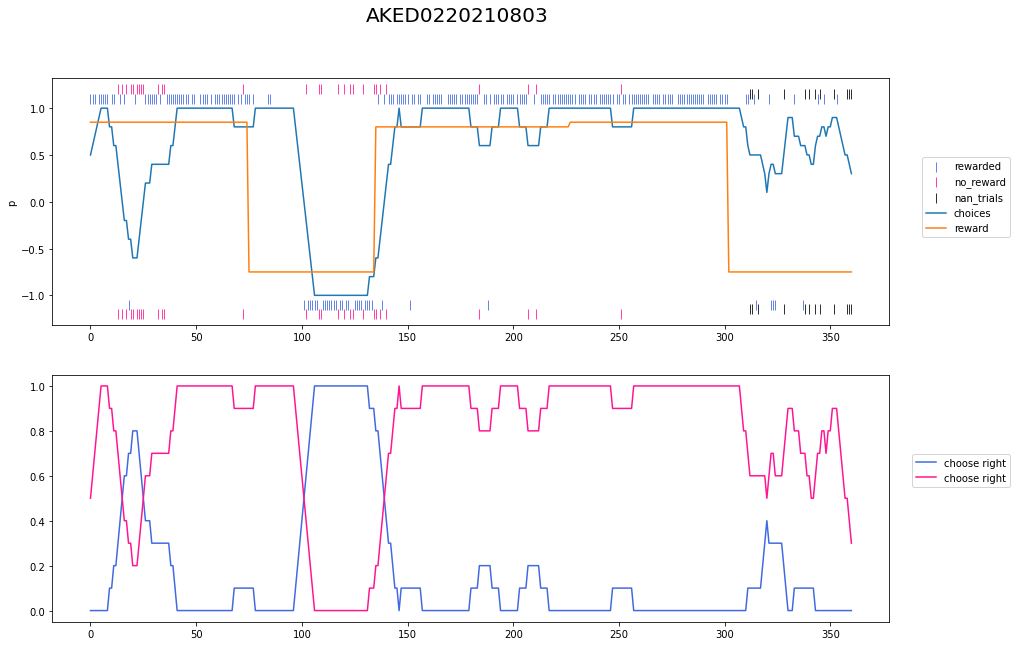

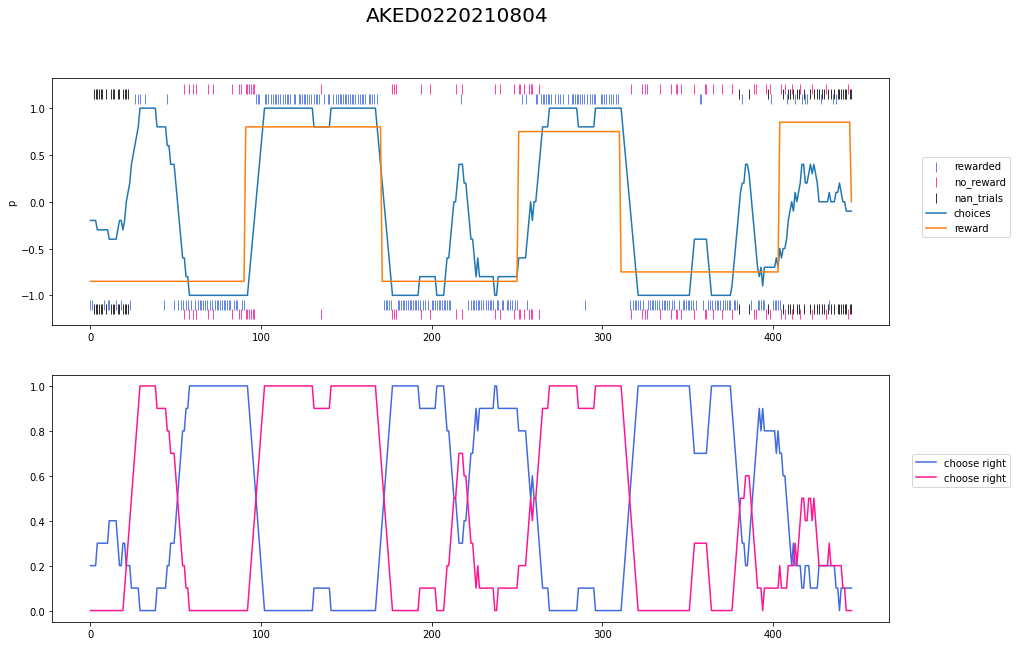

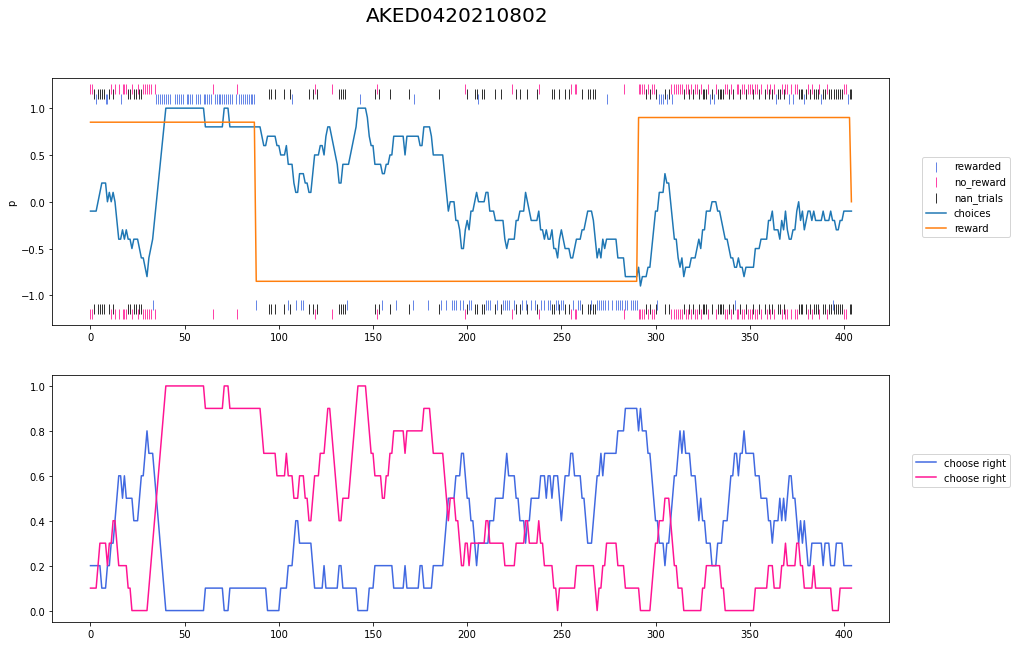

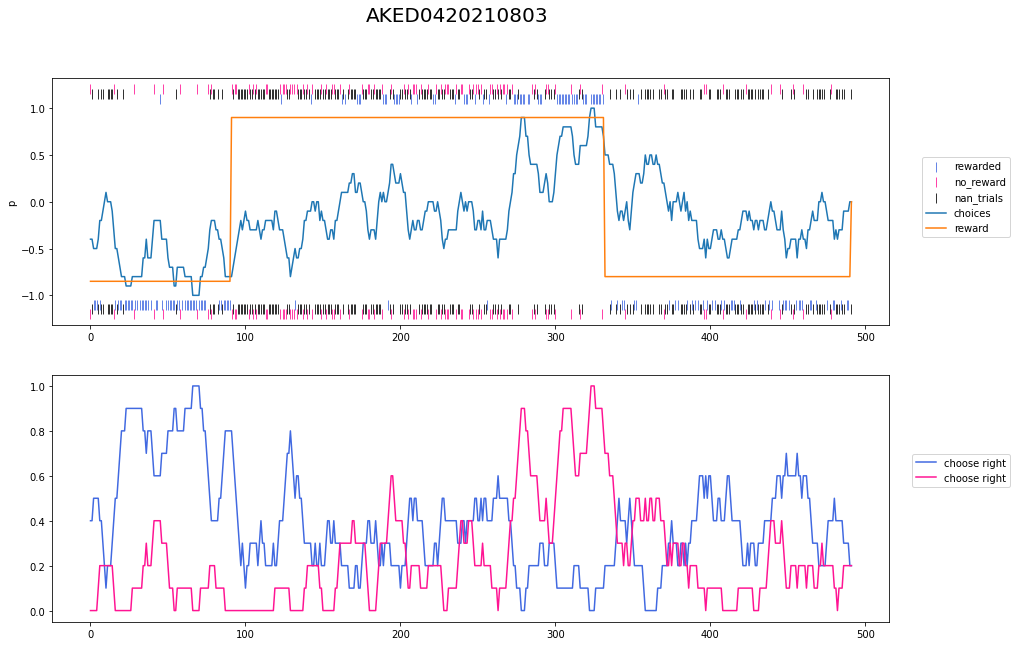

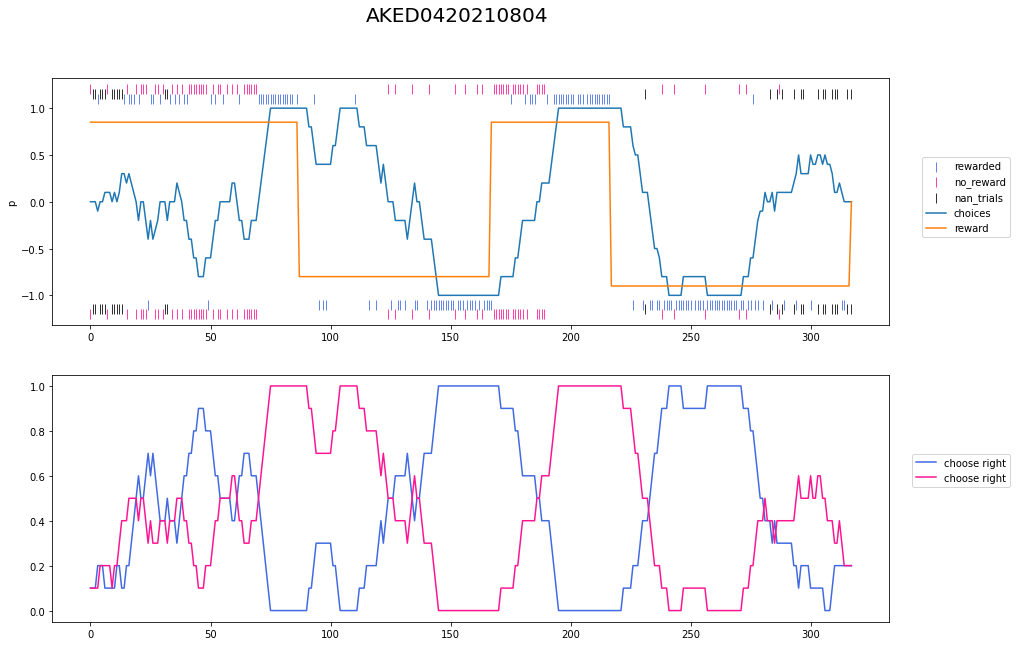

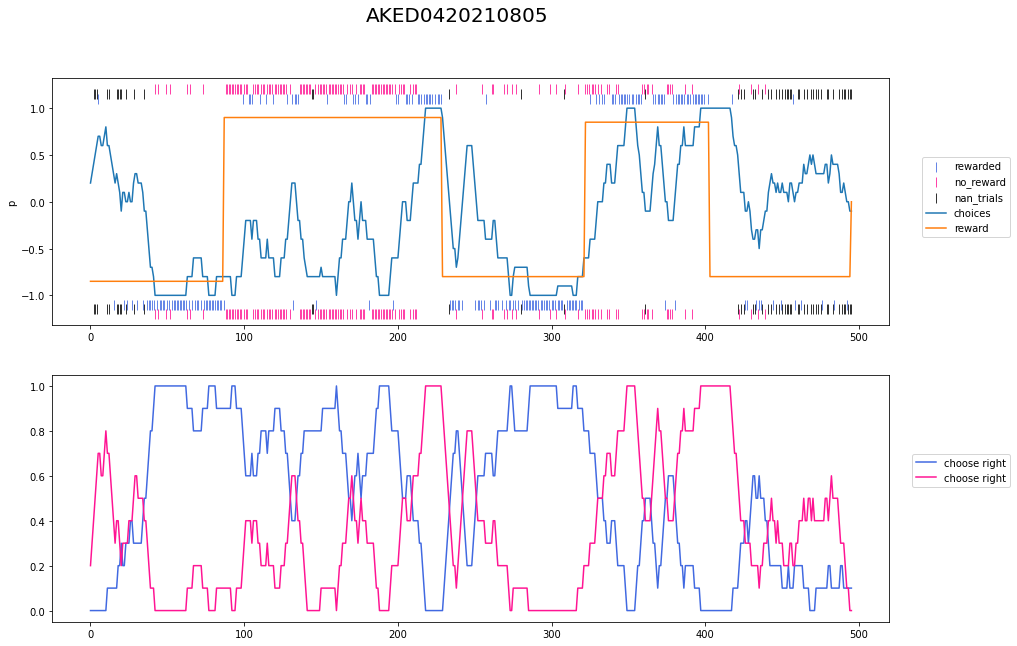

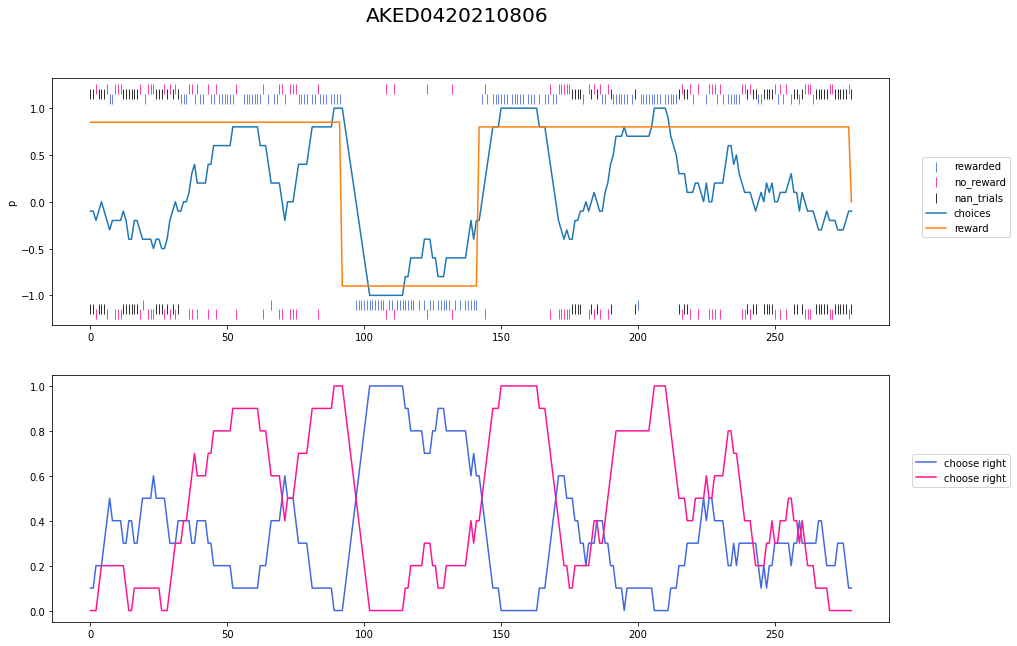

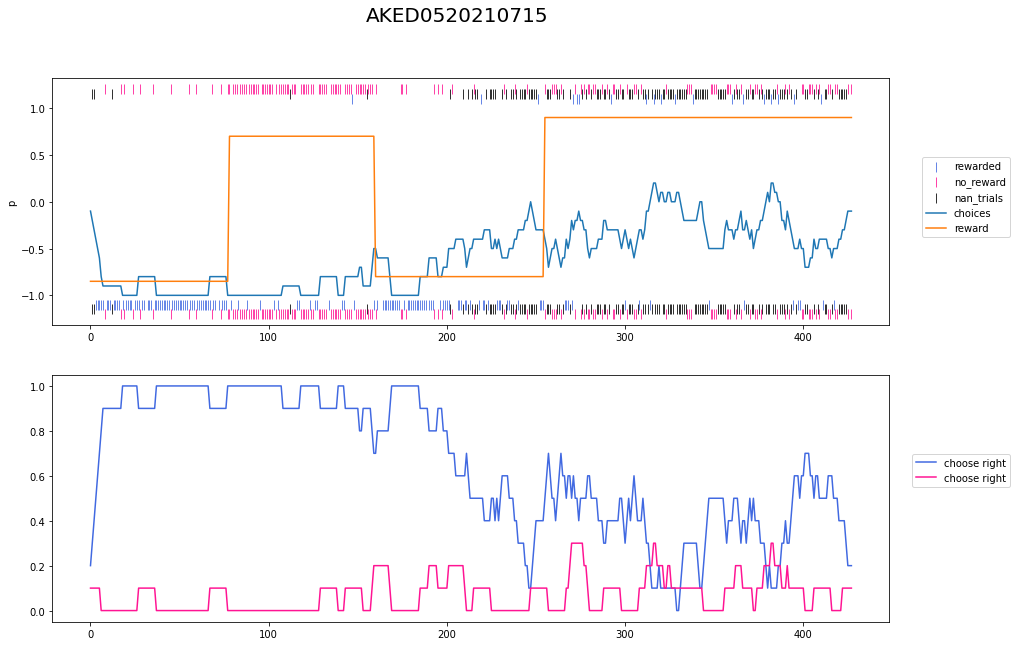

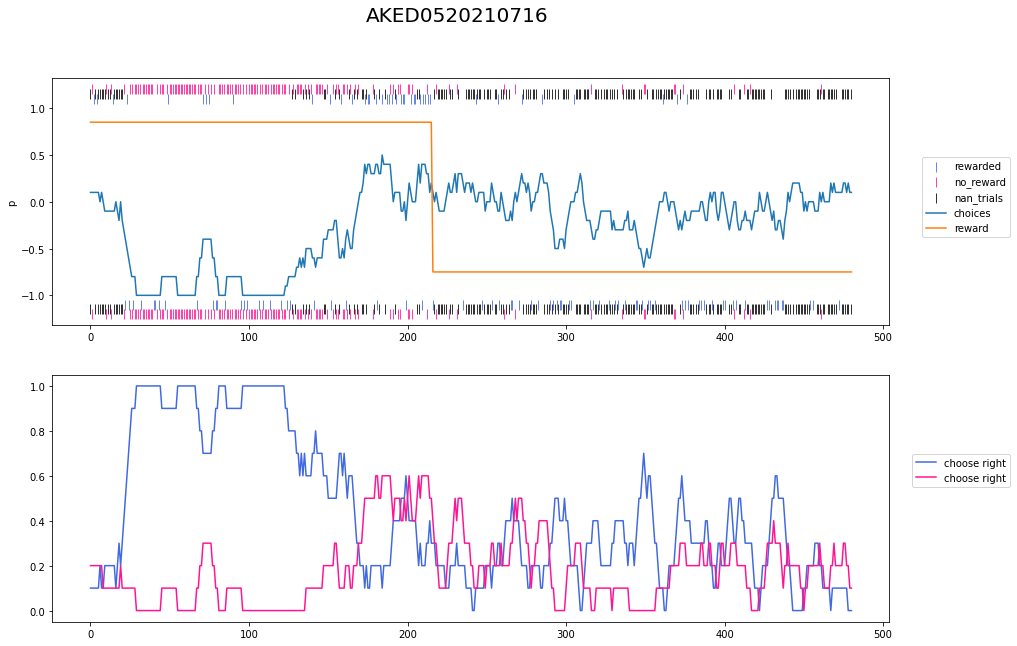

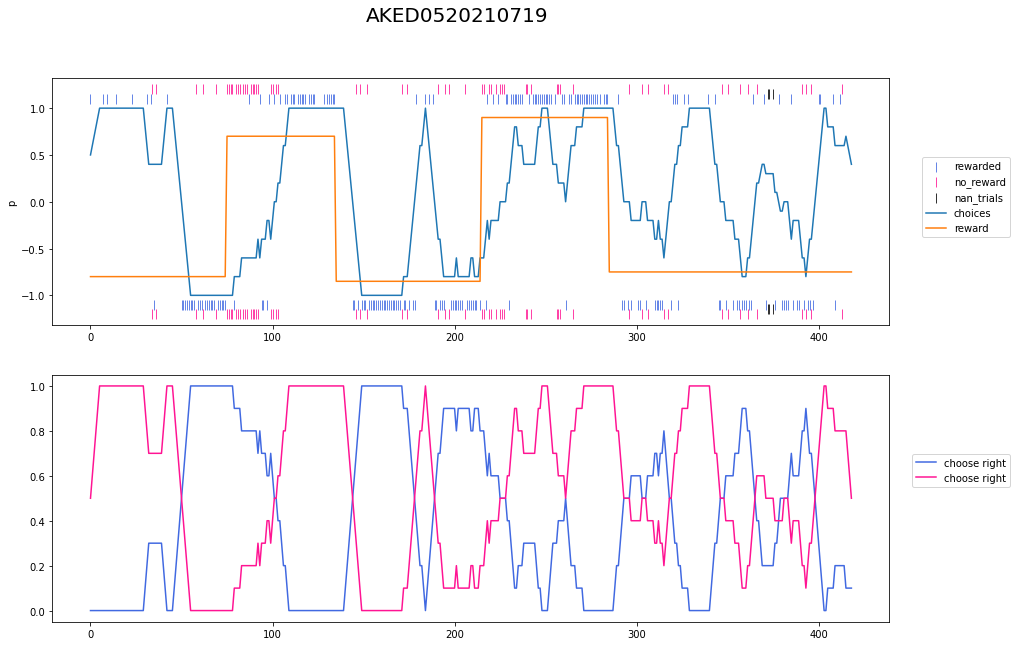

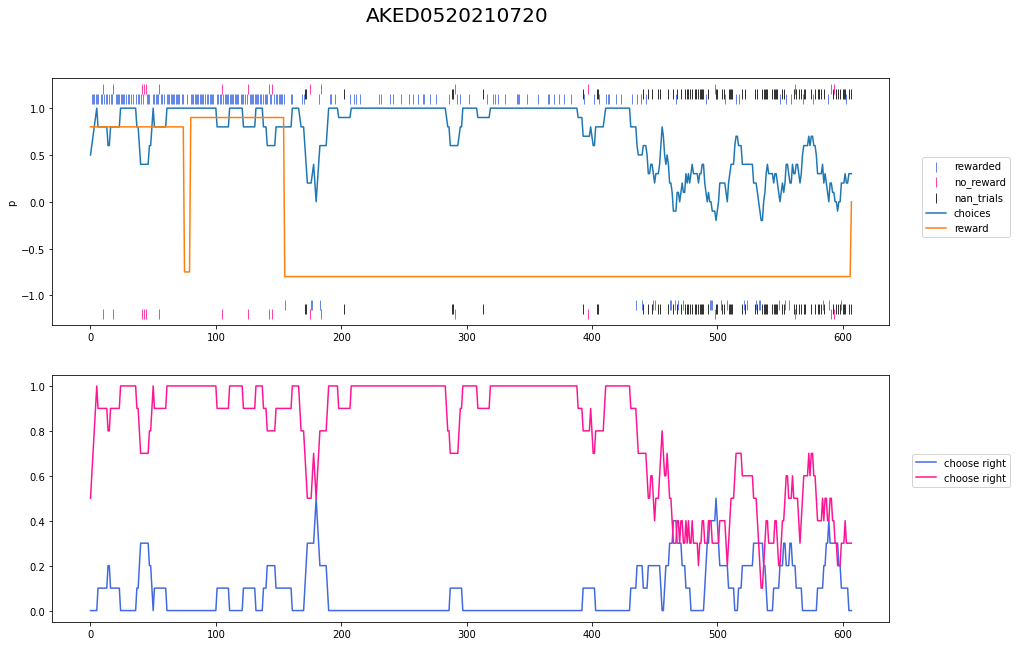

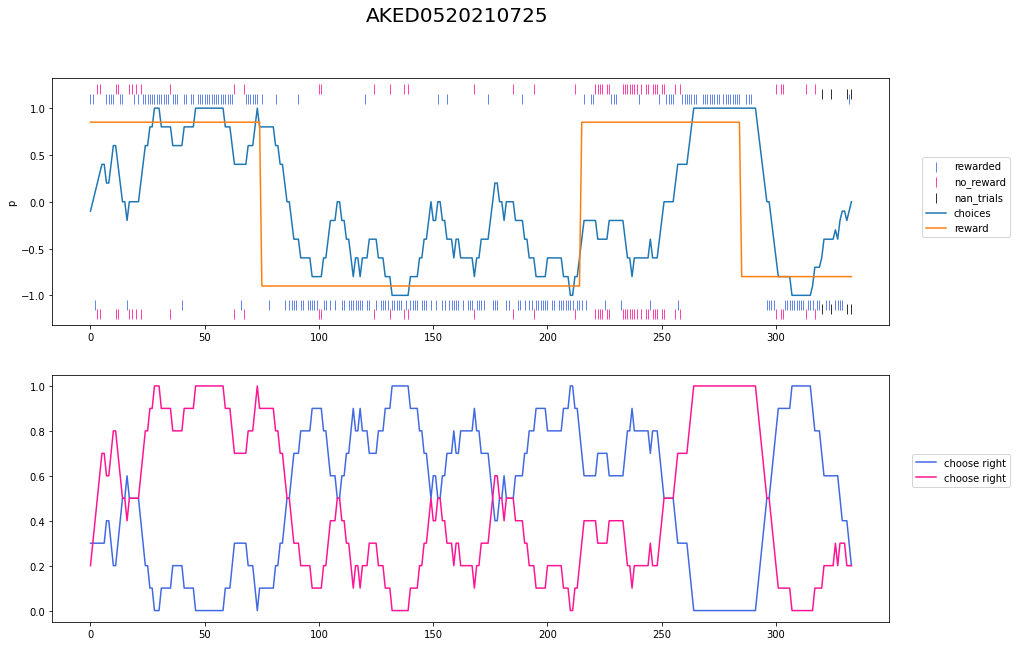

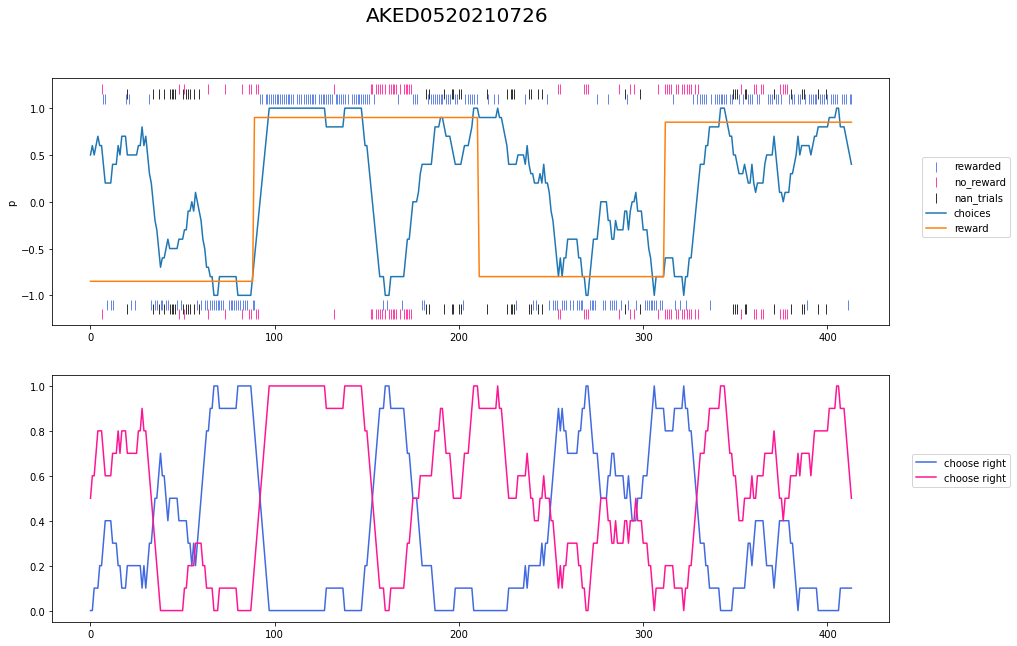

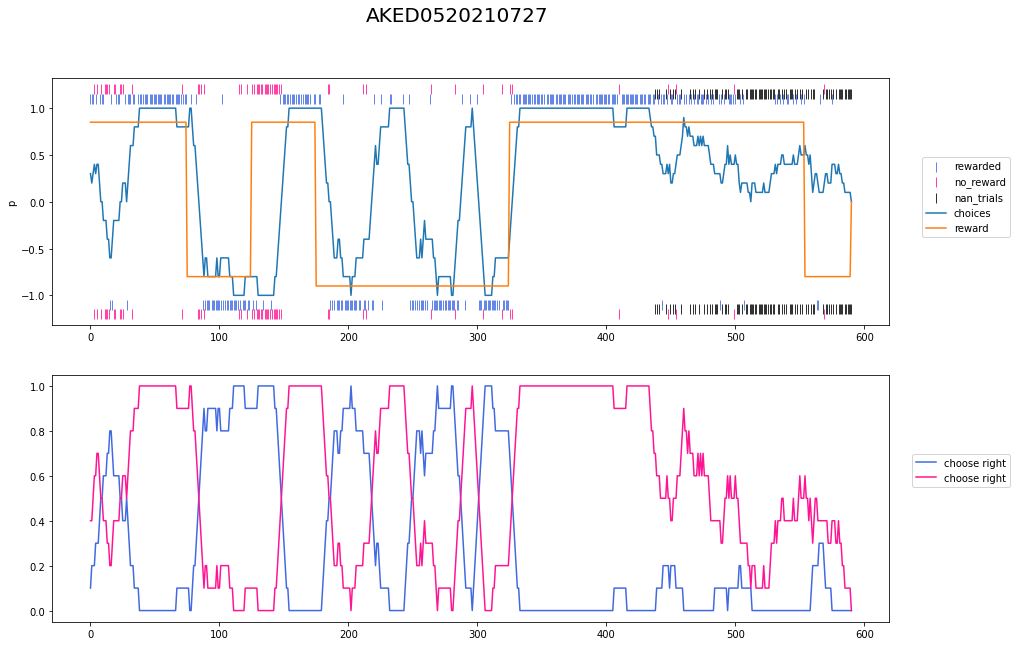

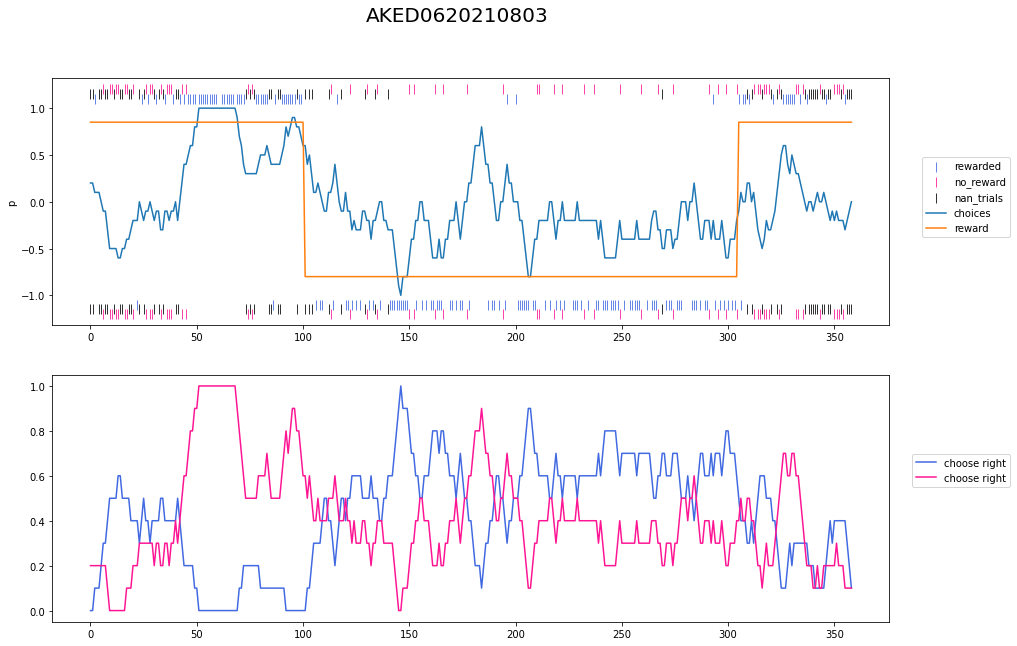

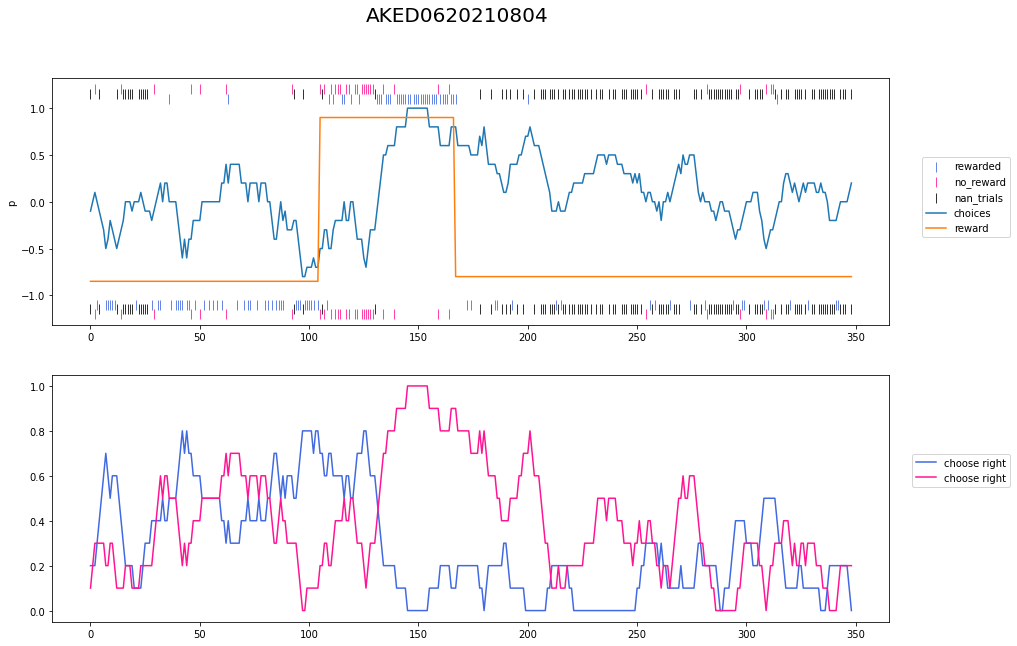

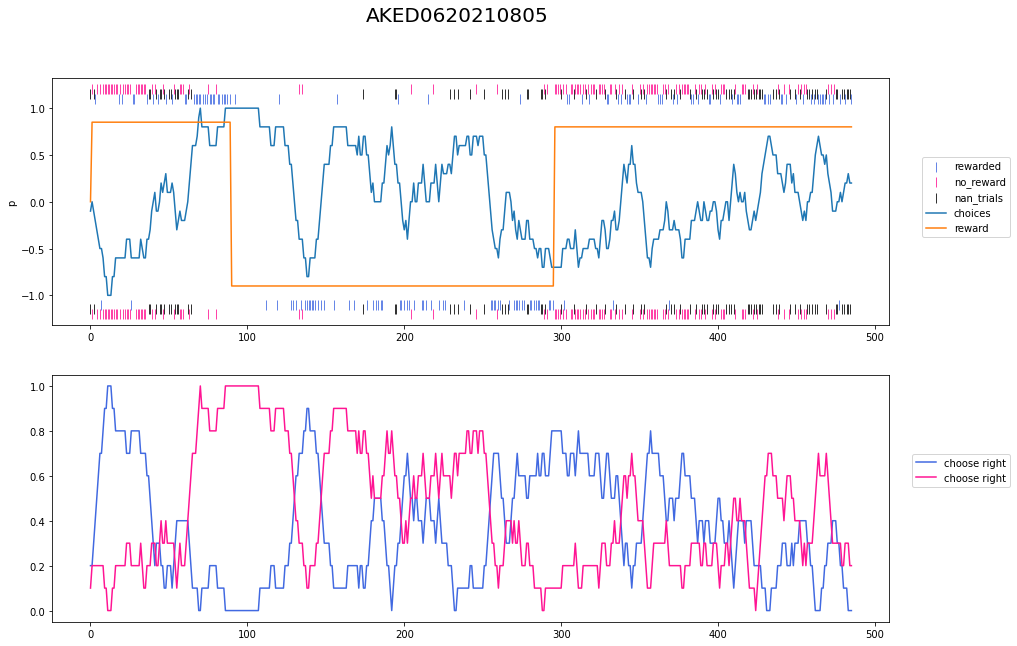

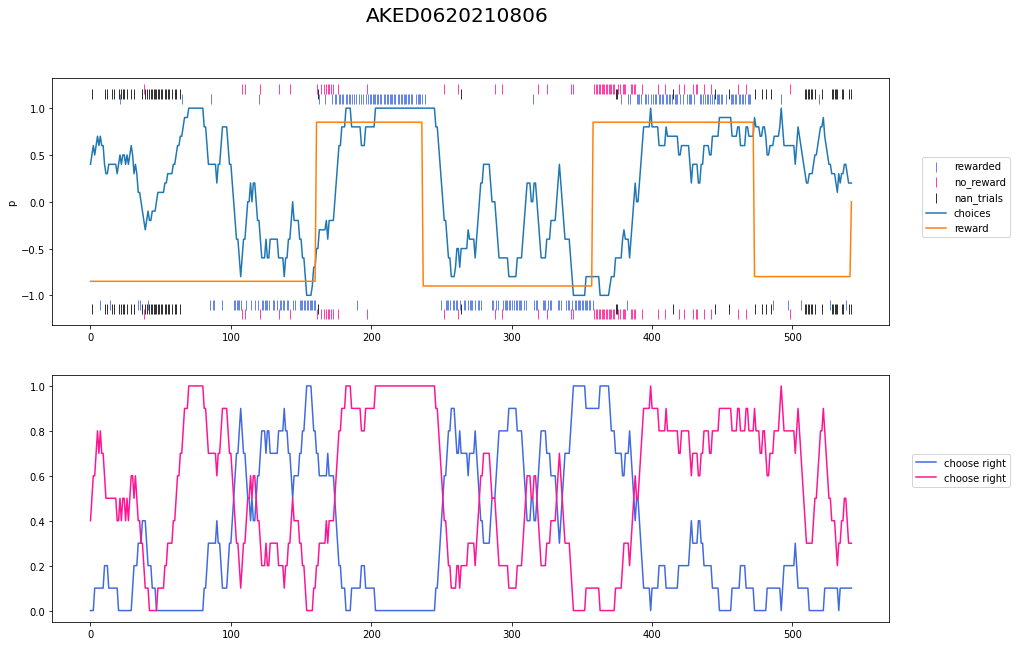

In [3]:
def panel_A(df: pd.DataFrame, name):
    # preprocessing data
    # fill nan values with 0s
    indices = range(df.shape[0])

    df = df.fillna(0)
    nan_trials = df[df['trial_response_side'] == 0].index.tolist()
    left_rewarded = df[(df['trial_response_side'] == -1) & (df['trial_reward'] == 1)].index.tolist()
    right_rewarded = df[(df['trial_response_side'] == 1) & (df['trial_reward'] == 1)].index.tolist()
    left_unrewarded = df[(df['trial_response_side'] == -1) & (df['trial_reward'] == 0)].index.tolist()
    right_unrewarded = df[(df['trial_response_side'] == -1) & (df['trial_reward'] == 0)].index.tolist()

    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle(name, fontsize=20)

    sns.scatterplot(x=right_rewarded, y=1.1, marker='|', color='royalblue', ax=axes[0], s=100)
    sns.scatterplot(x=left_rewarded, y=-1.1, marker='|', color='royalblue', ax=axes[0], s=100, label='rewarded')
    sns.scatterplot(x=right_unrewarded, y=1.2, marker='|', color='deeppink', ax=axes[0], s=100, label='no_reward')
    sns.scatterplot(x=left_unrewarded, y=-1.2, marker='|', color='deeppink', ax=axes[0], s=100)
    sns.scatterplot(x=nan_trials, y=-1.15, marker='|', color='black', ax=axes[0], s=100, label='nan_trials')
    sns.scatterplot(x=nan_trials, y=1.15, marker='|', color='black', ax=axes[0], s=100)

    responses = np.convolve(df['trial_response_side'].to_numpy(), np.ones(10)/10, mode='same')
    sns.lineplot(x=indices, y=responses.reshape(1, -1)[0], ax=axes[0], label='choices')

    left_choices = df[df['trial_response_side'] == 1].index.tolist()
    right_choices = df[df['trial_response_side'] == -1].index.tolist()
    left_c = np.zeros(len(df))
    left_c[left_choices] = 1
    left_c = np.convolve(left_c, np.ones(10)/10, mode='same')
    right_c = np.zeros(len(df))
    right_c[right_choices] = 1
    right_c = np.convolve(right_c, np.ones(10)/10, mode='same')
    sns.lineplot(x=indices, y=right_c, color='royalblue', label='choose right', ax=axes[1])
    sns.lineplot(x=indices, y=left_c, color='deeppink', label='choose left', ax=axes[1])

    # sns.scatterplot(x=left_choices, y=1.1, marker='o', color='deeppink', ax=axes[1], s=10, label='left_choices')
    # sns.scatterplot(x=nan_trials, y=1.1, marker='o', color='black', ax=axes[1], s=10, label='nan_trials')
    # sns.scatterplot(x=right_choices, y=1.1, marker='o', color='royalblue', ax=axes[1], s=10, label='right_choices')

    df['p'] = df[['leftP', 'rightP']].max(axis=1)
    left = df[df['leftP'] > df['rightP']].index.tolist()
    df.iloc[left] = df.iloc[left].mul(-1)
    sns.lineplot(x=indices, y=df['p'], ax=axes[0], label='reward')

    axes[0].legend(bbox_to_anchor=(1.15, 0.7))
    axes[1].legend(bbox_to_anchor=(1.15, 0.7))

    plt.savefig(pjoin('figure_4', 'panel_A',name + '.tiff'), dpi=300)

for file in listdir(pjoin('behaviour_data', 'csv')):
    path = pjoin('behaviour_data', 'csv', file)
    df = pd.read_csv(path)
    panel_A(df, file.split('.')[0])

## Panel B

## Panel D

#### How to calculate 'Decay constant'??

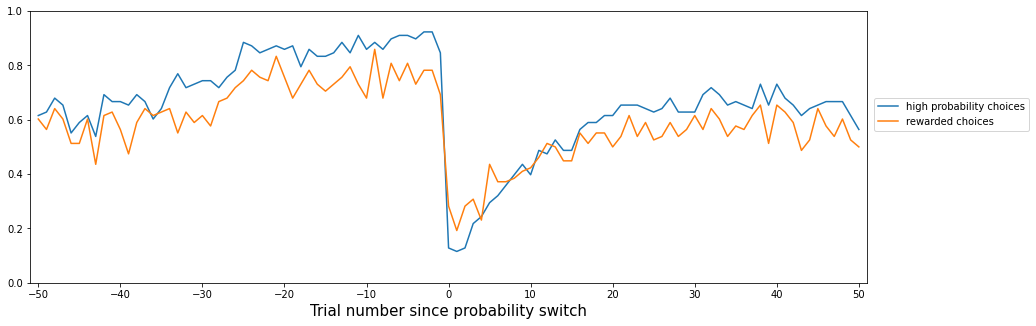

In [20]:
WINDOW = 50
high_P_all = []
rewarded_all = []

def find_switch(df: pd.DataFrame):
    leftP = np.array(df['leftP'])
    switches = []

    for ind, p in enumerate(leftP):
        if ind == 0:
            continue
        if p != (leftP[ind-1]):
            if ind - WINDOW > 0 and ind + WINDOW < len(leftP):
                windowed = df.iloc[ind-WINDOW:ind+WINDOW+1]
                windowed = windowed.reset_index()
                rewarded_all.append(np.array(windowed['trial_reward']))
                highP = np.zeros(WINDOW * 2 + 1)
                highP_ind = windowed[((windowed['leftP'] > 0.5) & 
                                      (windowed['trial_response_side'] == -1)) |
                                      ((windowed['rightP'] > 0.5) &
                                      (windowed['trial_response_side'] == 1))].index.tolist()
                highP[highP_ind] = 1
                high_P_all.append(highP)
                

for file in listdir(pjoin('behaviour_data', 'csv')):
    path = pjoin('behaviour_data', 'csv', file)
    df = pd.read_csv(path)
    df = df.fillna(0)
    find_switch(df)

high_P_all = np.array(high_P_all)
rewarded_all = np.array(rewarded_all)

high_P_averaged = high_P_all.mean(axis=0)
rewarded_averaged = rewarded_all.mean(axis=0)

# high_P_averaged = np.convolve(high_P_all.mean(axis=0), np.ones(10)/10, mode='same')
# rewarded_averaged = np.convolve(rewarded_all.mean(axis=0), np.ones(10)/10, mode='same')


fig, axes = plt.subplots(1, 1, figsize=(15, 5))

sns.lineplot(x=range(-50, 51), y=high_P_averaged, ax=axes, label='high probability choices')
sns.lineplot(x=range(-50, 51), y=rewarded_averaged, ax=axes, label='rewarded choices')

axes.set_ybound(0, 1)
axes.set_xlim([-51, 51])
axes.set_xticks(range(-50, 51, 10))
axes.set_xlabel('Trial number since probability switch', fontsize=15)

axes.legend(bbox_to_anchor=(1.2, 0.7))

plt.savefig(pjoin('figure_4', 'panel_D', 'panel_D.tiff'), dpi=300)